In [1]:
from TinySAM import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader

# Setting Up Models

In [2]:
GroundingModel = GDino()
SAMModel = SAM2()

# Load Data to RAM

In [ ]:
data = ZeroShotObjectDetectionDataset('./Data/cityscapes/',do_preprocess=False, processor=GroundingModel.processor)

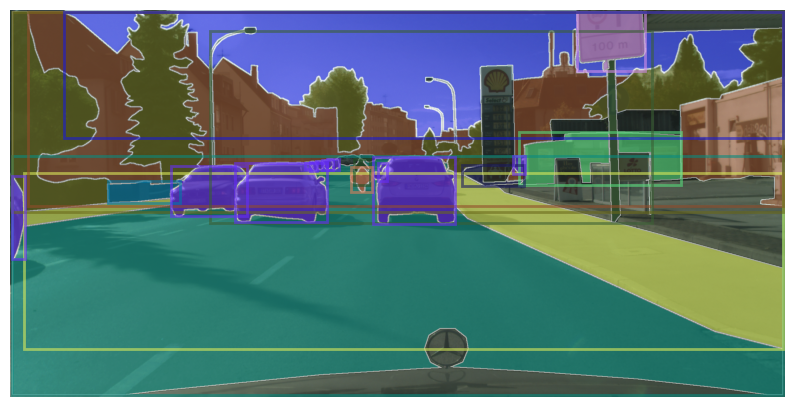

In [ ]:
# visualize a random sample
rnd_idx = np.random.randint(0,len(data))
data.visualize(rnd_idx)

# Run Grounding Dino

In [5]:
batch_size = 8
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)

boxes = []
labels = []
scores = []

# get the text prompts
input_ids = data.input_prompt_ins.input_ids.to(GroundingModel.device)
target_image_size = data.image_size

for batch in tqdm(dataloader):
    outputs = GroundingModel(batch.to(GroundingModel.device), input_ids=input_ids, target_image_size=target_image_size)
    
    for out in outputs:
        boxes.append(out['boxes'].cpu().numpy())
        labels.append(out['labels'])
        scores.append(out['scores'].cpu().numpy())
        for i in range(len(labels[-1])):
            # only pick first label for any dual predictions
            if labels[-1][i] + '.' not in data.text_prompts:
                labels[-1][i] = labels[-1][i].split(' ')[0]

  0%|          | 0/63 [00:00<?, ?it/s]

# Run SAM2

In [6]:
masks = SAMModel(data.images, boxes)

  0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
# Save Results (if needed)
np.save('masks.npy', np.array(masks, dtype=object))
np.save('boxes.npy', np.array(boxes, dtype=object))
np.save('labels.npy', np.array(labels, dtype=object))
np.save('scores.npy', np.array(scores, dtype=object))

In [ ]:
# Load Results (if needed)
masks = np.load('masks.npy', allow_pickle=True)
boxes = np.load('boxes.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)
scores = np.load('scores.npy', allow_pickle=True)

# Visualize A Prediction

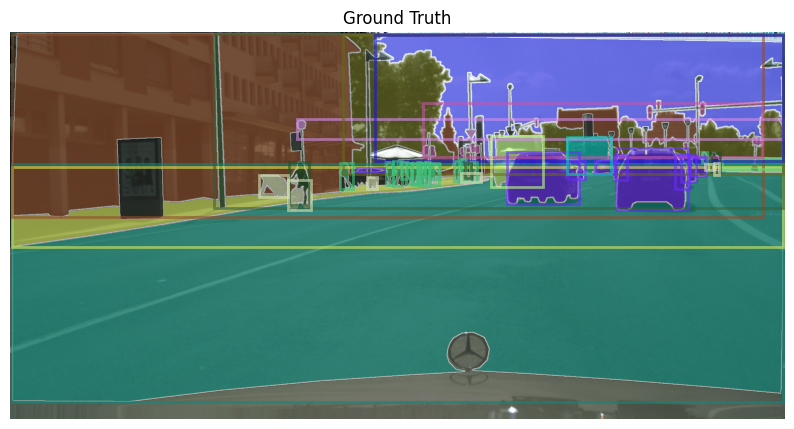

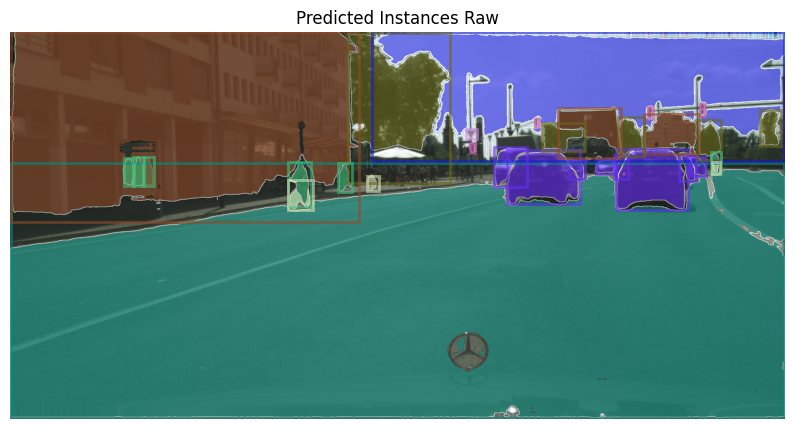

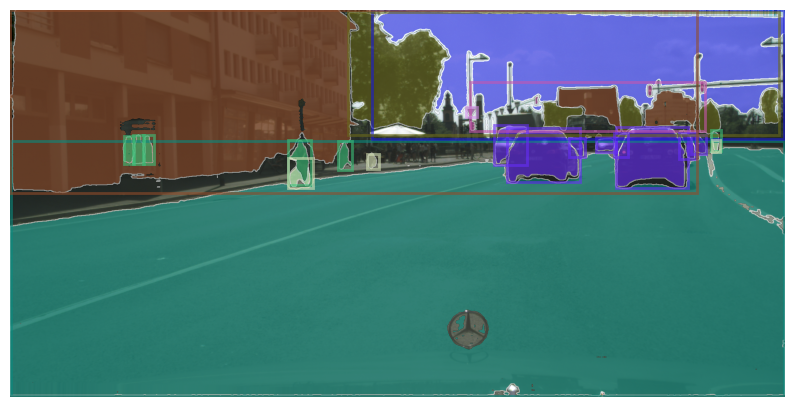

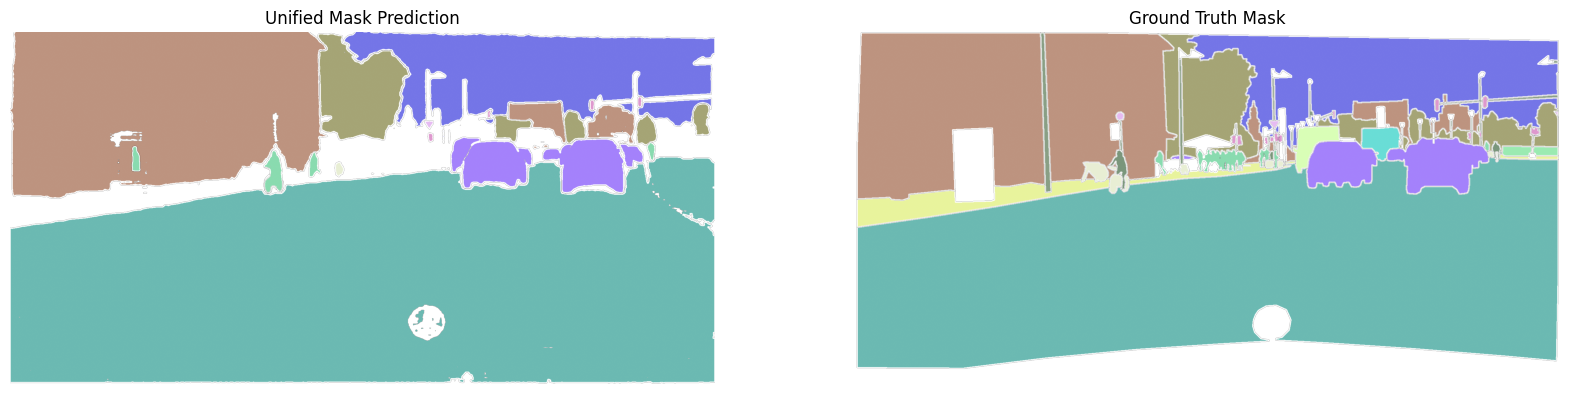

In [ ]:
rnd_idx = np.random.randint(0,len(data))
# visualize ground truth
data.visualize(rnd_idx)
plt.title('Ground Truth')

# visualize the predicted masks
data.visualize_prediction(rnd_idx, boxes[rnd_idx], masks[rnd_idx], labels[rnd_idx])
plt.title('Predicted Instances Raw')

# visualize the predicted masks after post-processing
data.visualize_prediction(rnd_idx, boxes[rnd_idx], masks[rnd_idx], labels[rnd_idx], unify=True)

In [ ]:
mIoU, mAP, overall_iou, processed_boxes, processed_labels, processed_masks, processed_scores, unified_masks = data.evaluate_precitions(boxes, labels, masks, scores, return_processed=True)

  0%|          | 0/500 [00:00<?, ?it/s]

Mean IoU:  tensor(0.0878)
Precision Scores:  {'map': tensor(0.2299), 'map_50': tensor(0.3184), 'map_75': tensor(0.2451), 'map_small': tensor(0.0085), 'map_medium': tensor(0.0668), 'map_large': tensor(0.3163), 'mar_1': tensor(0.2313), 'mar_10': tensor(0.2785), 'mar_100': tensor(0.2810), 'mar_small': tensor(0.0094), 'mar_medium': tensor(0.0908), 'mar_large': tensor(0.3828), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19], dtype=torch.int32)}


In [19]:
(data.label_ids[0] == unified_masks[0])[np.logical_and(data.label_ids[0] != 0, unified_masks[0] != 0)].sum() / ((data.label_ids[0]+unified_masks[0]) != 0).sum()

0.6752076009423181

In [13]:
unified_masks[0].max()

14

In [20]:
unified_masks

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [14]:
data.id_map

{1: 'road',
 2: 'sidewalk',
 3: 'building',
 4: 'wall',
 5: 'fence',
 6: 'pole',
 7: 'traffic light',
 8: 'traffic sign',
 9: 'trees',
 10: 'terrain',
 11: 'sky',
 12: 'person',
 13: 'rider',
 14: 'car',
 15: 'truck',
 16: 'bus',
 17: 'train',
 18: 'motorcycle',
 19: 'bicycle'}